In [1]:
from astropy.constants import c
from astropy.units import Quantity
import astropy.units as U
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
import math
import pyvo
import numpy as np 
import pandas as pd
import os 
import sys
import random
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns

master_path = os.path.dirname(os.getcwd())
service_url = "https://almascience.eso.org/tap"
service = pyvo.dal.TAPService(service_url)


In [2]:
def estimate_alma_beam_size(central_frequency_ghz, max_baseline_km, return_value=True):
  """
  Estimates the beam size of the Atacama Large Millimeter/submillimeter Array (ALMA) in arcseconds.

  This function provides an approximation based on the theoretical relationship between
  observing frequency and maximum baseline. The formula used is:
  beam_size = (speed_of_light / central_frequency) / max_baseline * (180 / pi) * 3600 arcseconds
  [km]/[s] * [s] / [km] = [radians] * [arcsec /radian] * [arcseconds/degree]

  Args:
      central_frequency_ghz: Central frequency of the observing band in GHz (float).
      max_baseline_km: Maximum baseline of the antenna array in kilometers (float).

  Returns:
      Estimated beam size in arcseconds (float).

  Raises:
      ValueError: If either input argument is non-positive.
  """

  # Input validation
  if central_frequency_ghz <= 0 or max_baseline_km <= 0:
    raise ValueError("Central frequency and maximum baseline must be positive values.")
    
  if type(central_frequency_ghz) != Quantity:
    central_frequency_ghz = central_frequency_ghz * U.GHz
  if type(max_baseline_km) != Quantity:
    max_baseline_km = max_baseline_km * U.km

  # Speed of light in meters per second
  light_speed = c.to(U.m / U.s).value

  # Convert frequency to Hz
  central_frequency_hz = central_frequency_ghz.to(U.Hz).value

  # Convert baseline to meters
  max_baseline_meters = max_baseline_km.to(U.m).value


  # Theoretical estimate of beam size (radians)
  theta_radians = (light_speed / central_frequency_hz) / max_baseline_meters

  # Convert theta from radians to arcseconds
  beam_size_arcsec = theta_radians * (180 / math.pi) * 3600 * U.arcsec
  if return_value == True:
    return beam_size_arcsec.value
  else:
    return beam_size_arcsec


In [3]:
def get_fov_from_band(band, antenna_diameter: int = 12, return_value=True):
    """
    This function returns the field of view of an ALMA band in arcseconds
    input: 
        band number (int): the band number of the ALMA band, between 1 and 10
        antenna_diameter (int): the diameter of the antenna in meters
    output:
        fov (astropy unit): the field of view in arcseconds

    """
    light_speed = c.to(U.m / U.s).value
    if band == 1:
        central_freq = 43 * U.GHz  
    elif band == 2:
        central_freq = 67 * U.GHz
    elif band == 3:
        central_freq = 100 * U.GHz
    elif band == 4:
        central_freq = 150 * U.GHz
    elif band == 5:
        central_freq = 217 * U.GHz
    elif band == 6:
        central_freq = 250 * U.GHz
    elif band == 7:
        central_freq = 353 * U.GHz
    elif band == 8:
        central_freq = 545 * U.GHz
    elif band == 9:
        central_freq = 650 * U.GHz    
    elif band == 10:
        central_freq = 868.5 * U.GHz
    central_freq = central_freq.to(U.Hz).value
    central_freq_s = 1 / central_freq
    wavelength = light_speed * central_freq_s
    # this is the field of view in Radians
    fov = 1.22 * wavelength / antenna_diameter
    # fov in arcsec
    fov = fov * (180 / math.pi) * 3600 * U.arcsec
    if return_value == True:
        return fov.value
    else:
        return fov

In [4]:
def get_band_central_freq(band):
    """
    Takes as input the band number and returns its central frequency in GHz
    """
    if band == 1:
        return 38
    elif band == 2:
        return 78.5
    elif band == 3:
        return 100
    elif band == 4:
        return  143
    elif band == 5:
        return  217
    elif band == 6:
        return 250
    elif band == 7:
        return 353
    elif band == 8:
        return 545
    elif band == 9:
        return 650
    elif band == 10:
        return 850

In [5]:
def get_max_baseline_from_antenna_array(antenna_array, master_path):
    antenna_coordinates = pd.read_csv(os.path.join(master_path, 'antenna_config', 'antenna_coordinates.csv'))
    obs_antennas = antenna_array.split(' ')
    obs_antennas = [antenna.split(':')[0] for antenna in obs_antennas]
    obs_coordinates = antenna_coordinates[antenna_coordinates['name'].isin(obs_antennas)]
    max_baseline = 2 * np.max(np.sqrt(obs_coordinates['x'].values**2 + obs_coordinates['y'].values**2 + obs_coordinates['z'].values**2)) / 1000
    return max_baseline

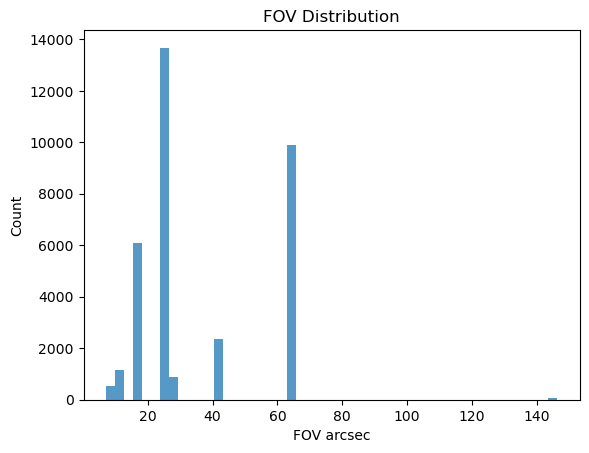

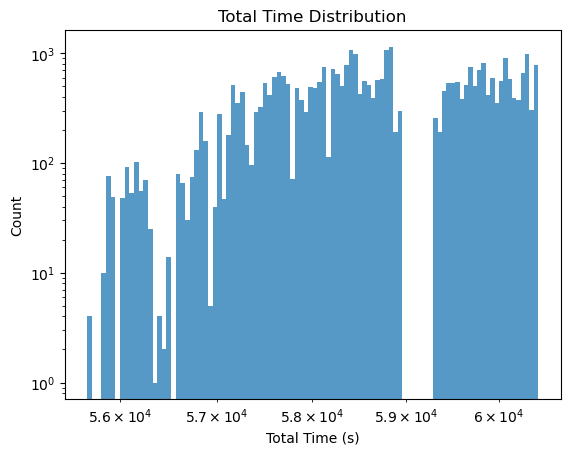

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


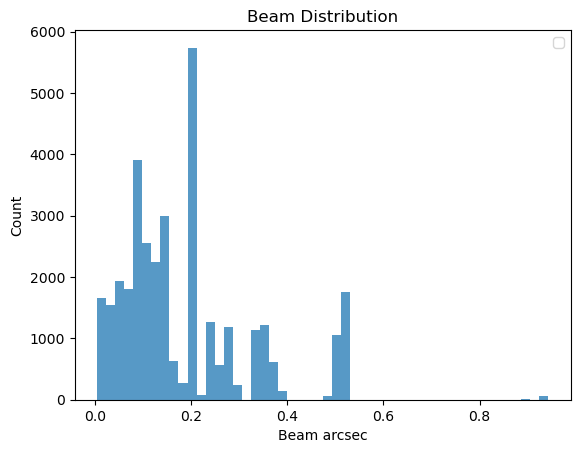

C:\Users\lsann\AppData\Local\Temp\ipykernel_13340\4238559069.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  db_sk_f = db.groupby(['science_keyword', 'frequency_bin']).size().unstack(fill_value=0)
C:\Users\lsann\AppData\Local\Temp\ipykernel_13340\4238559069.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  db_sk_t = db.groupby(['science_keyword', 'time_bin']).size().unstack(fill_value=0)
C:\Users\lsann\AppData\Local\Temp\ipykernel_13340\4238559069.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

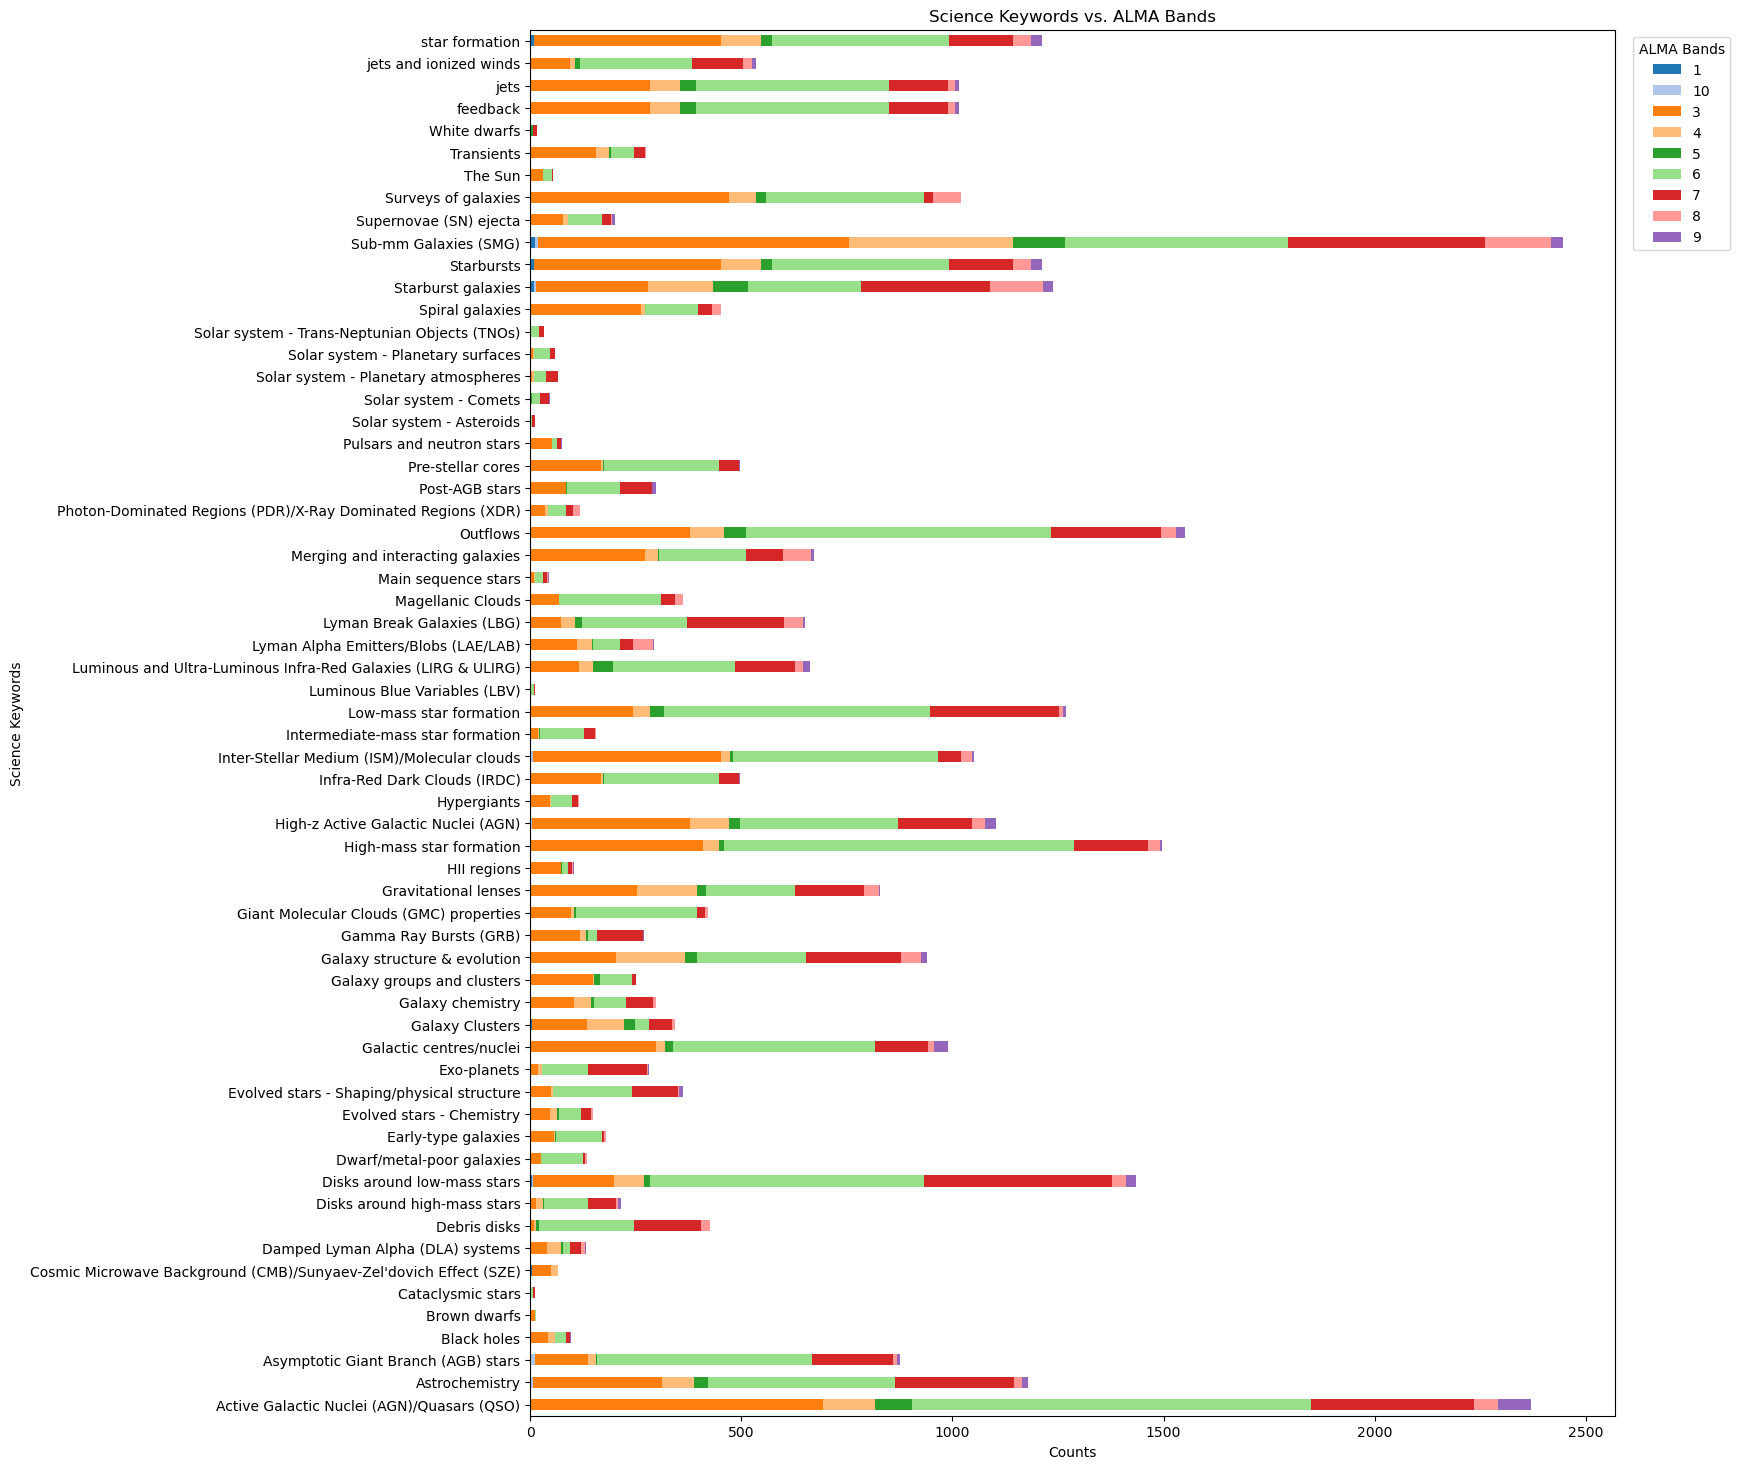

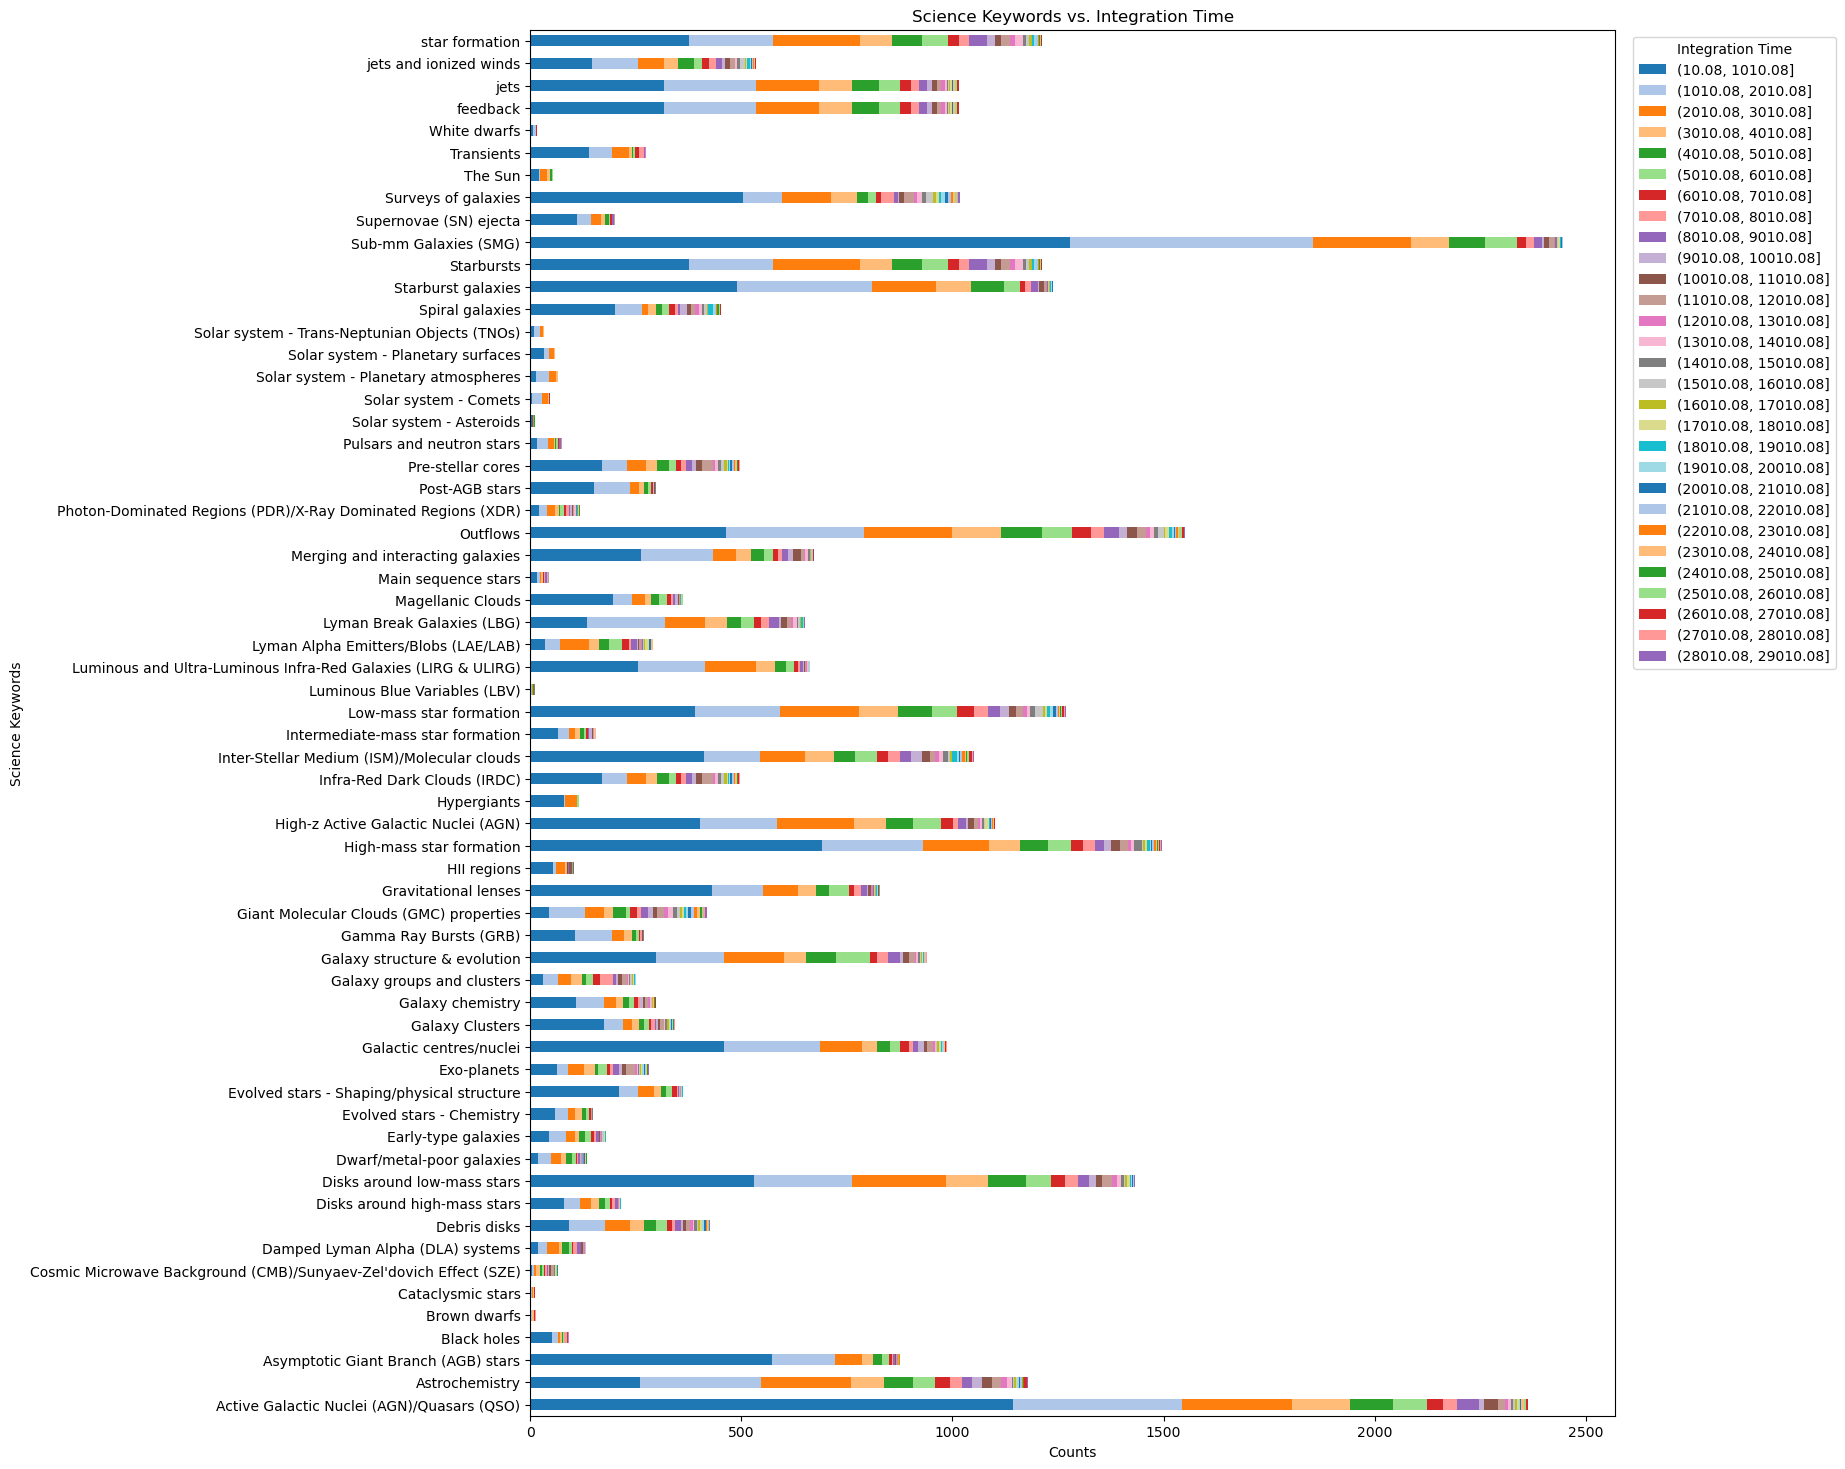

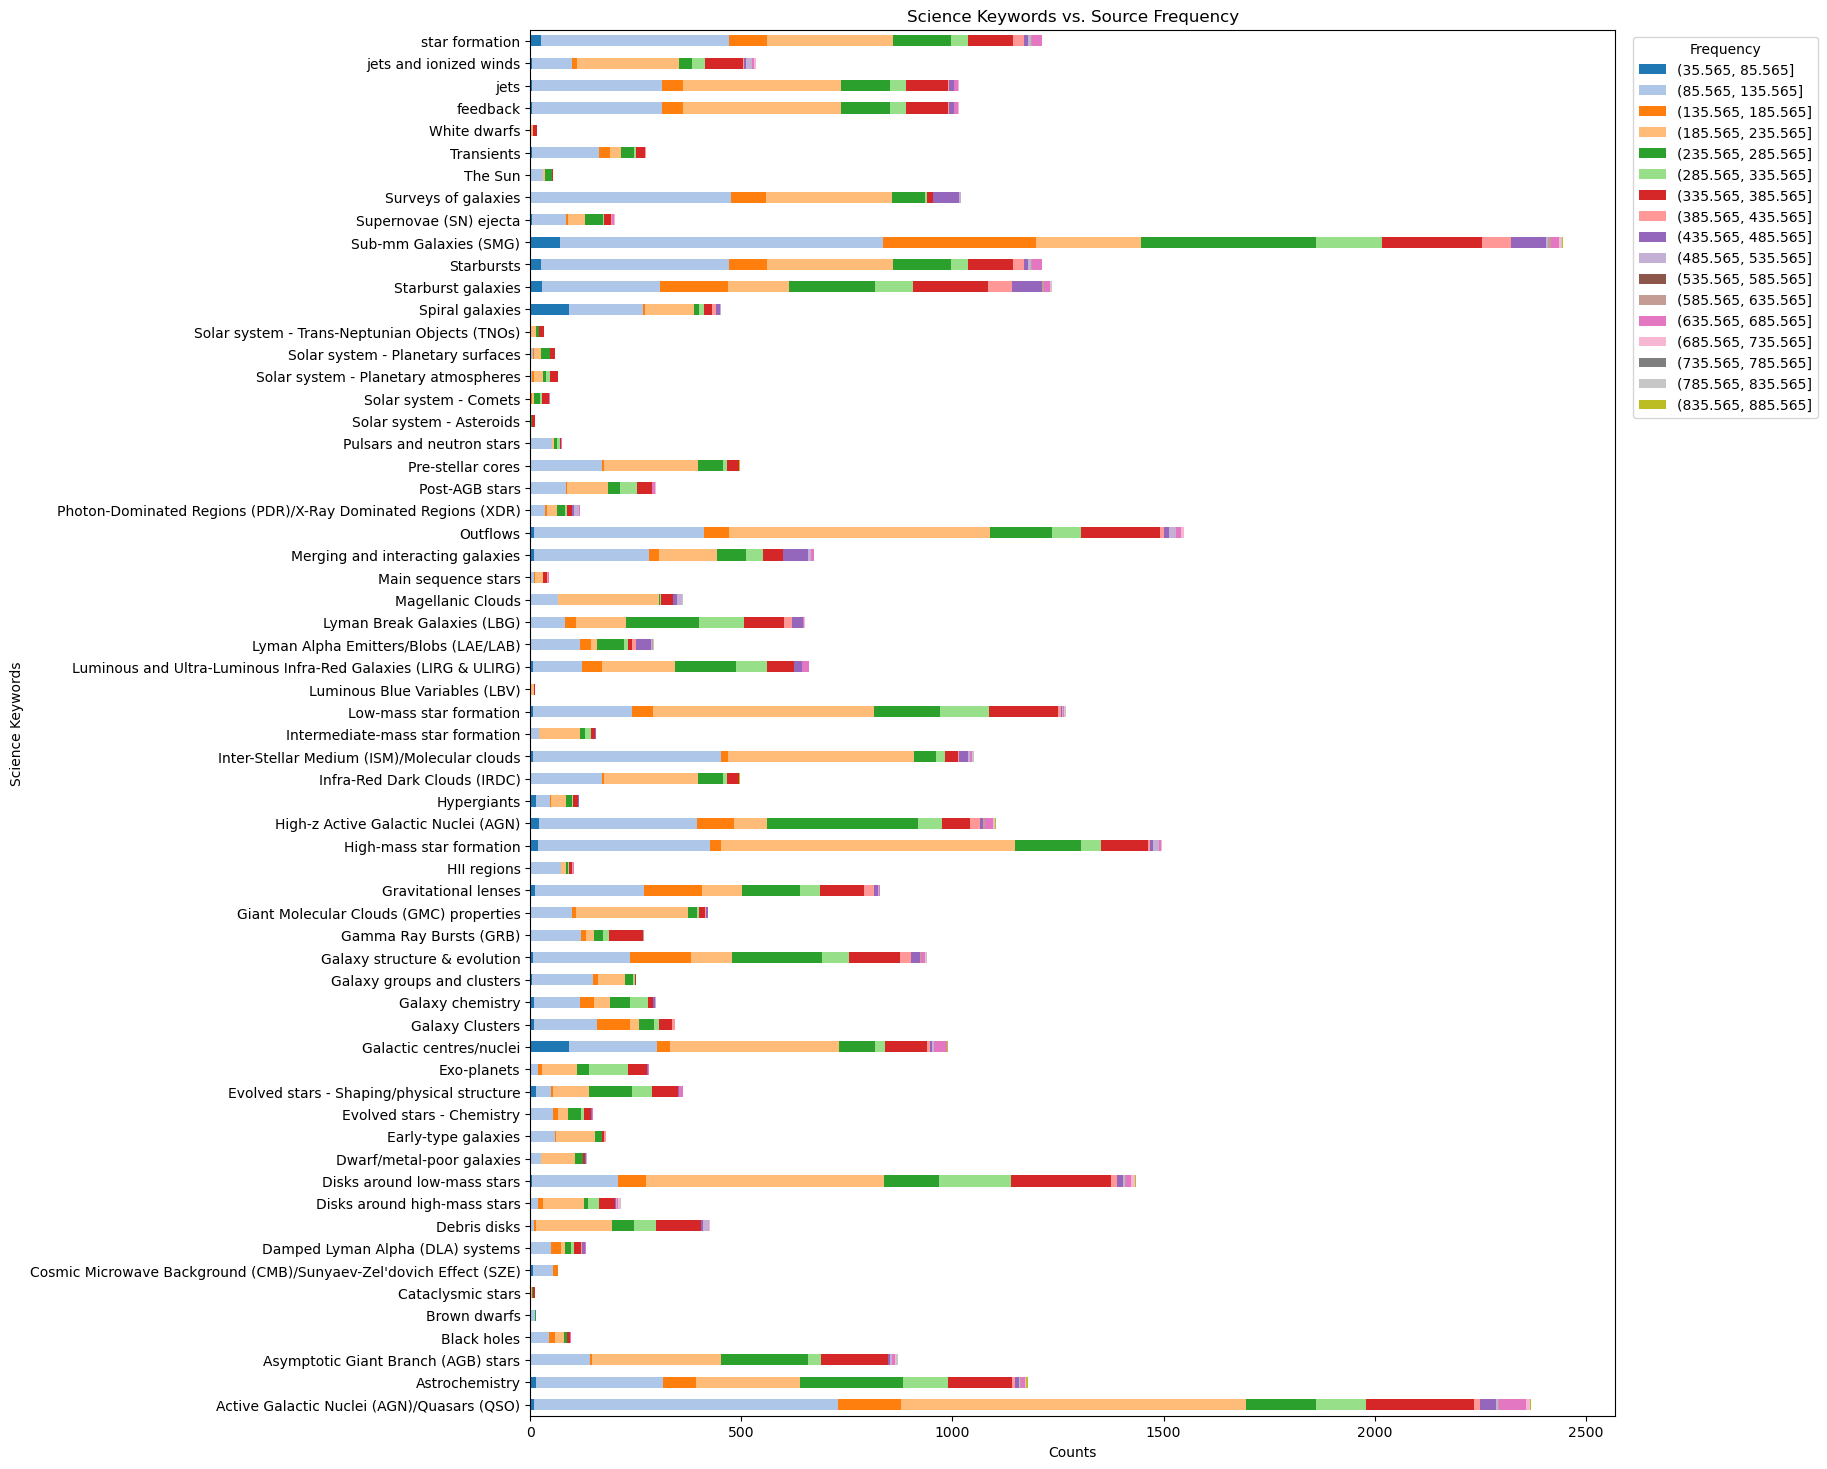

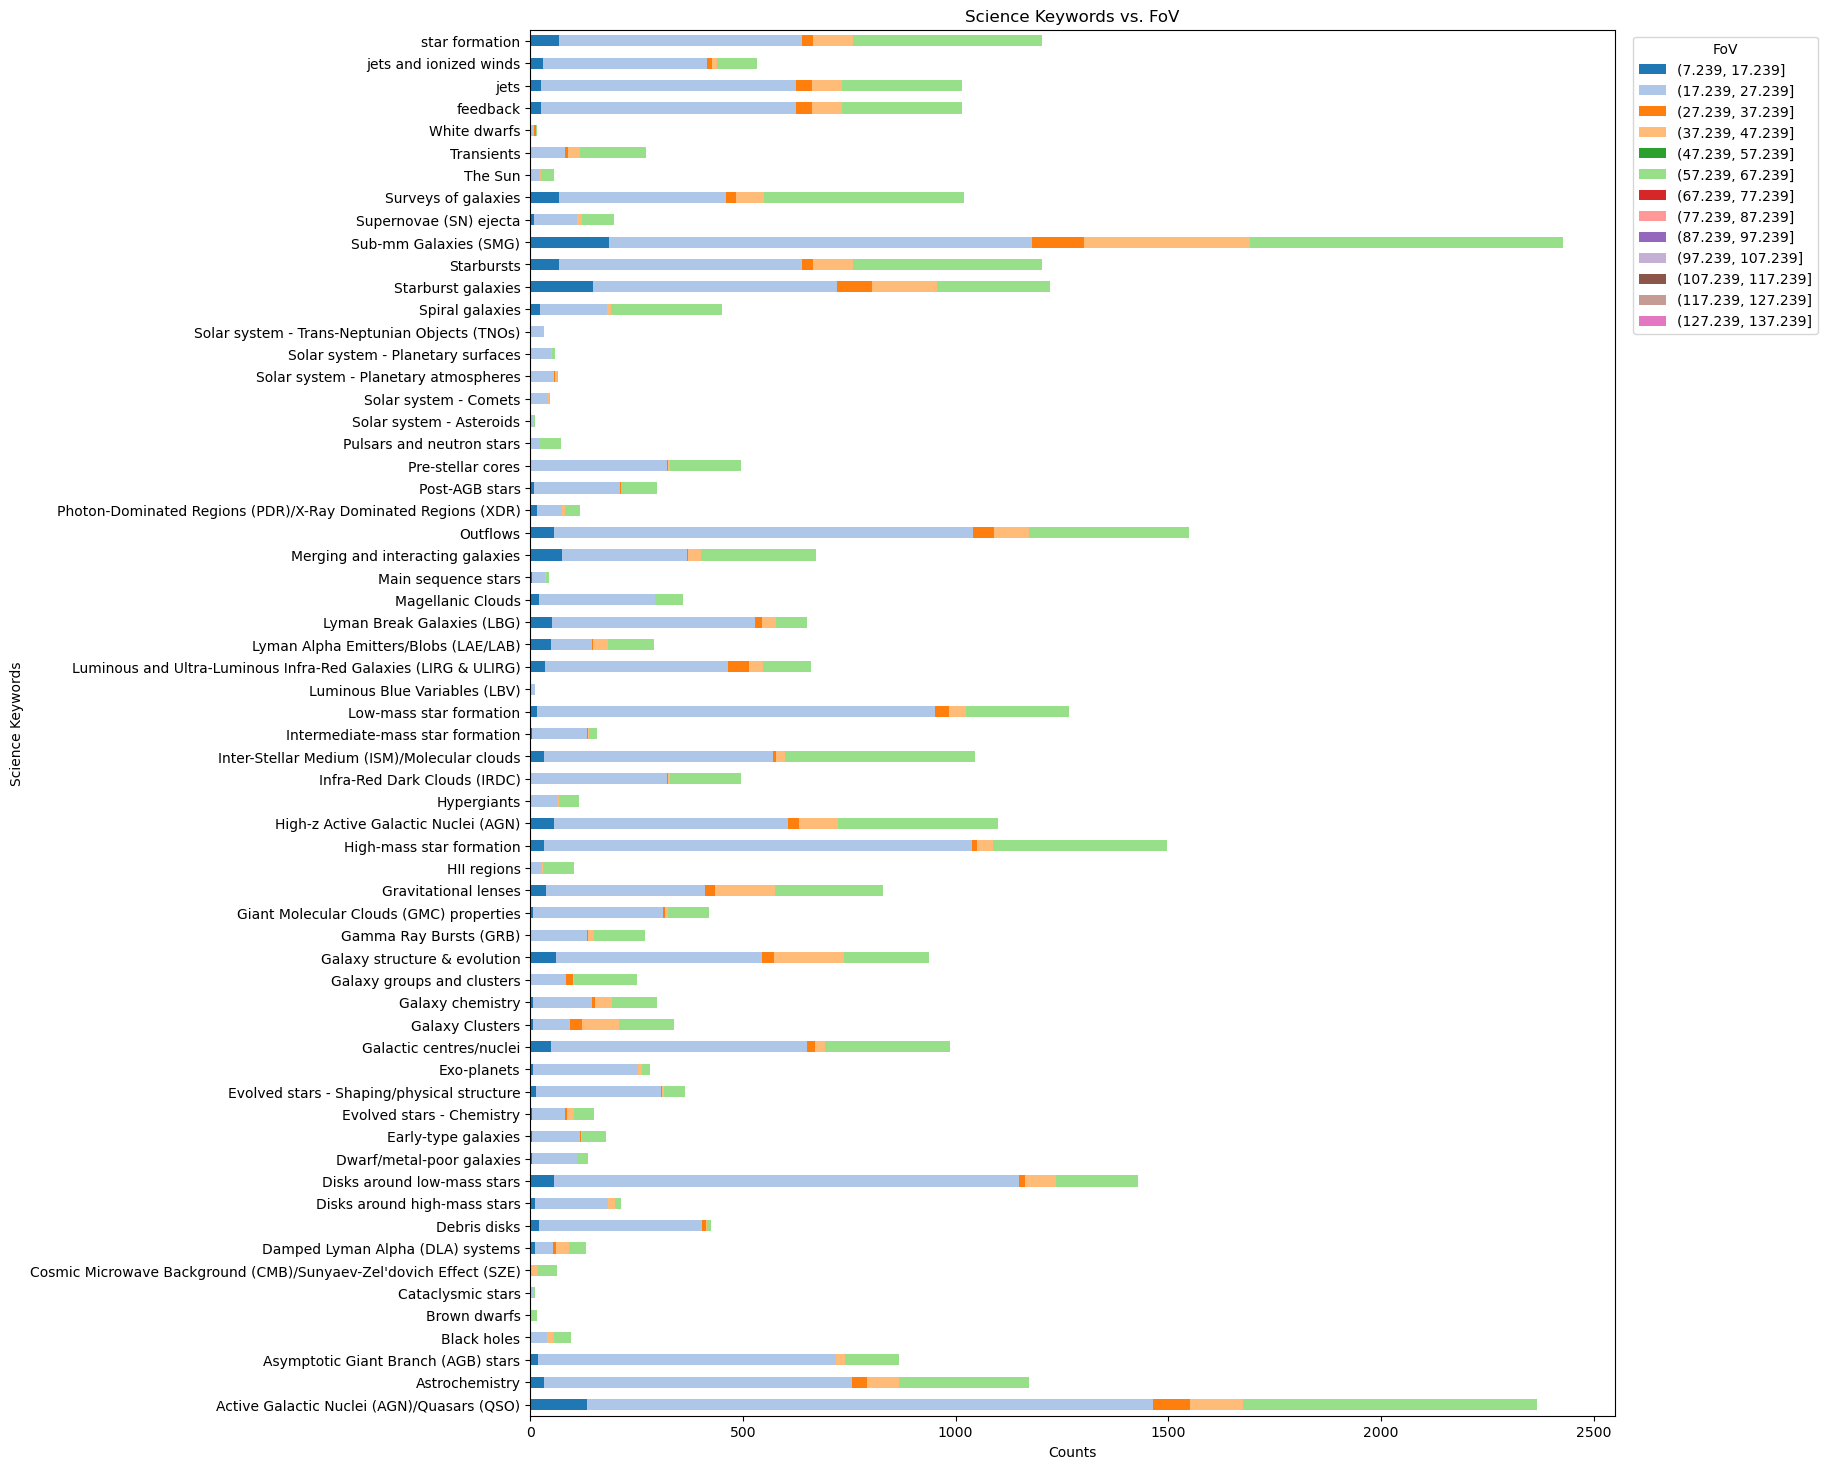

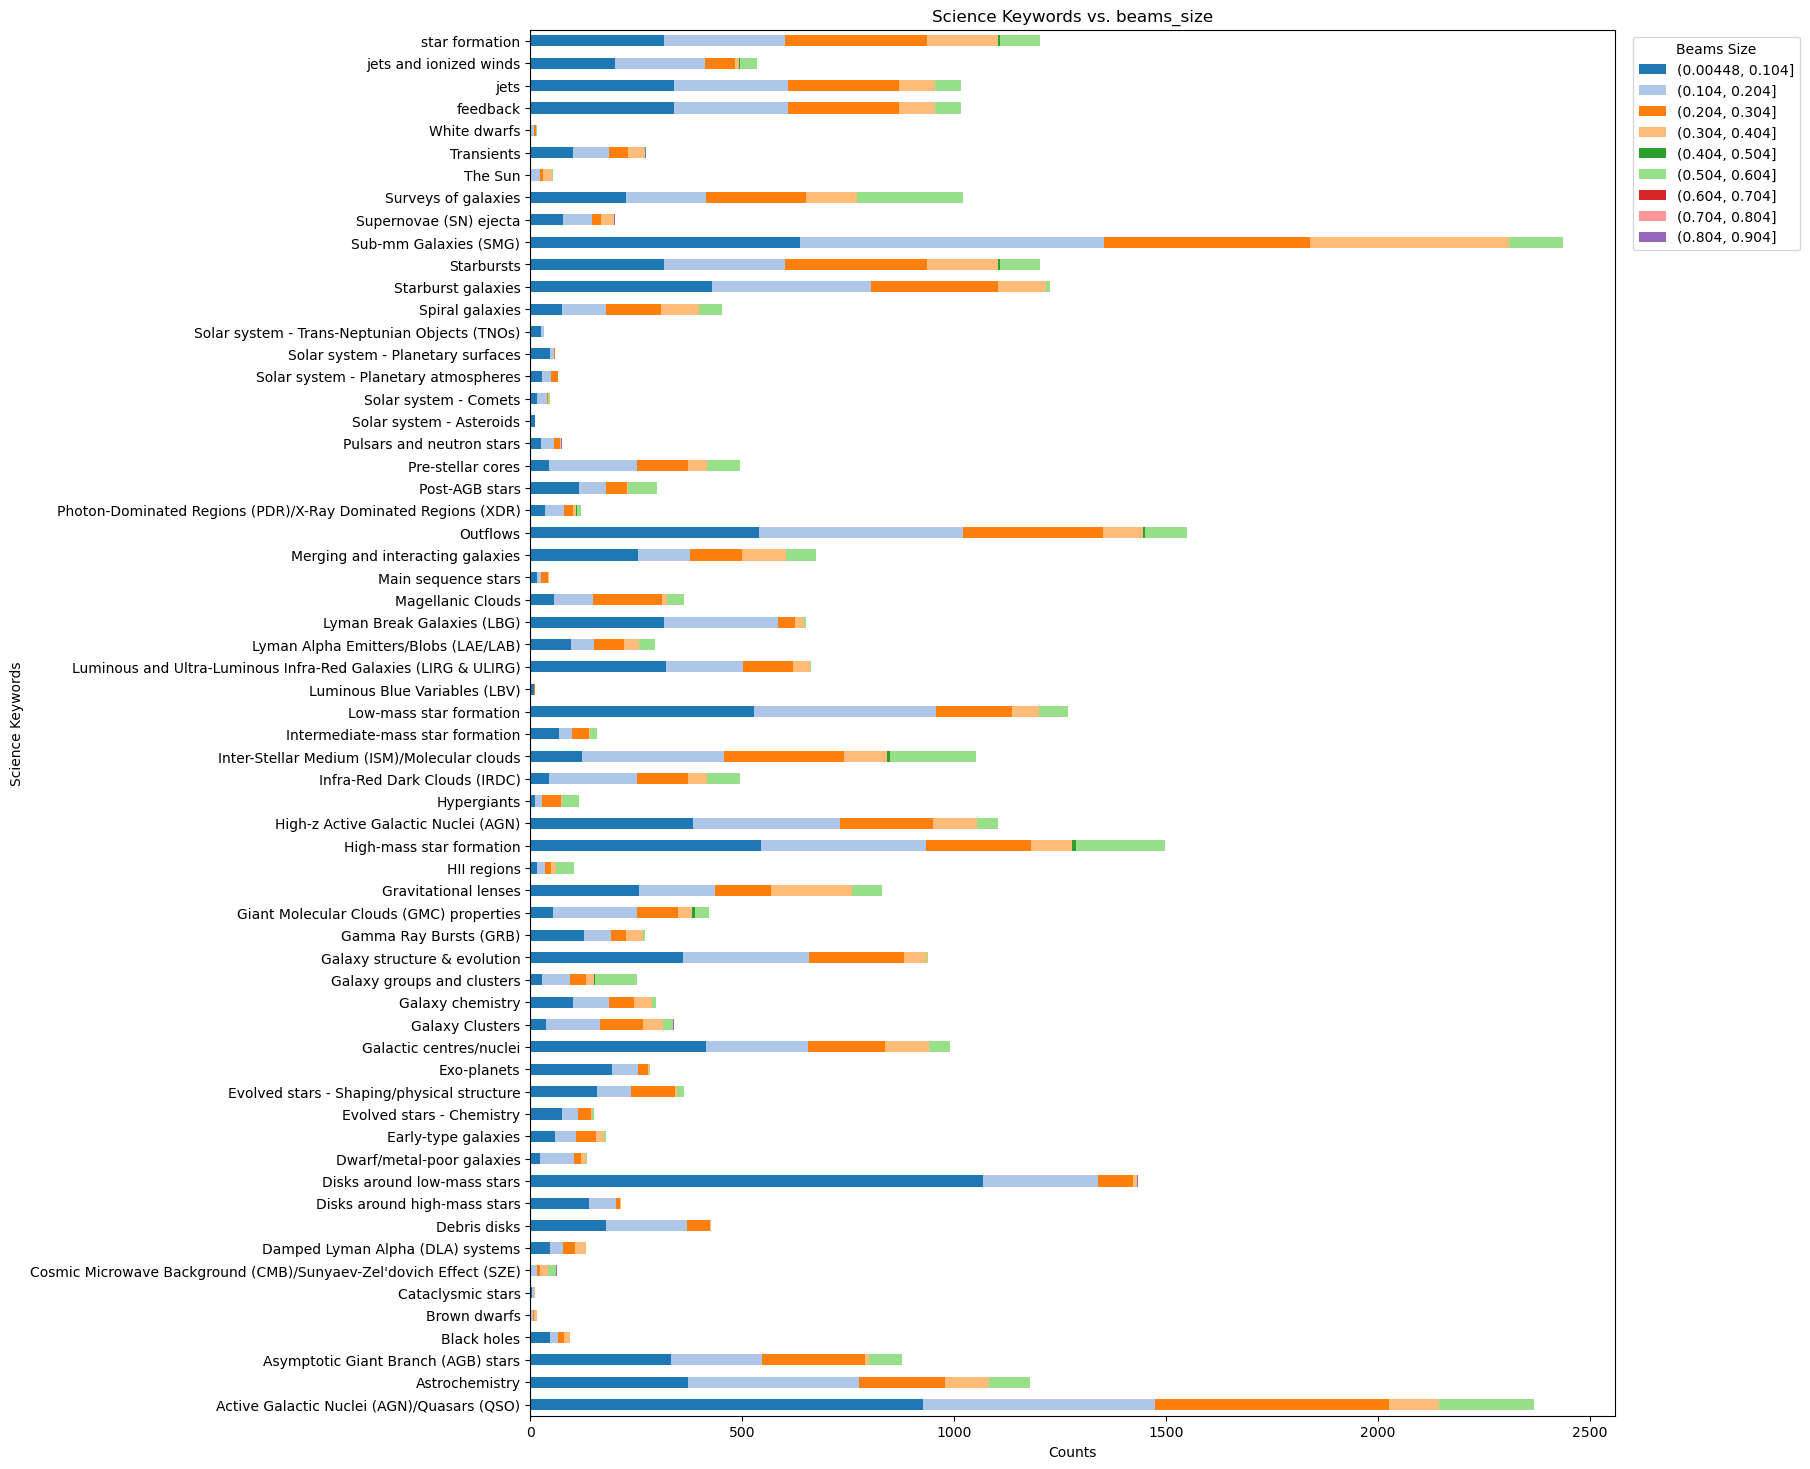

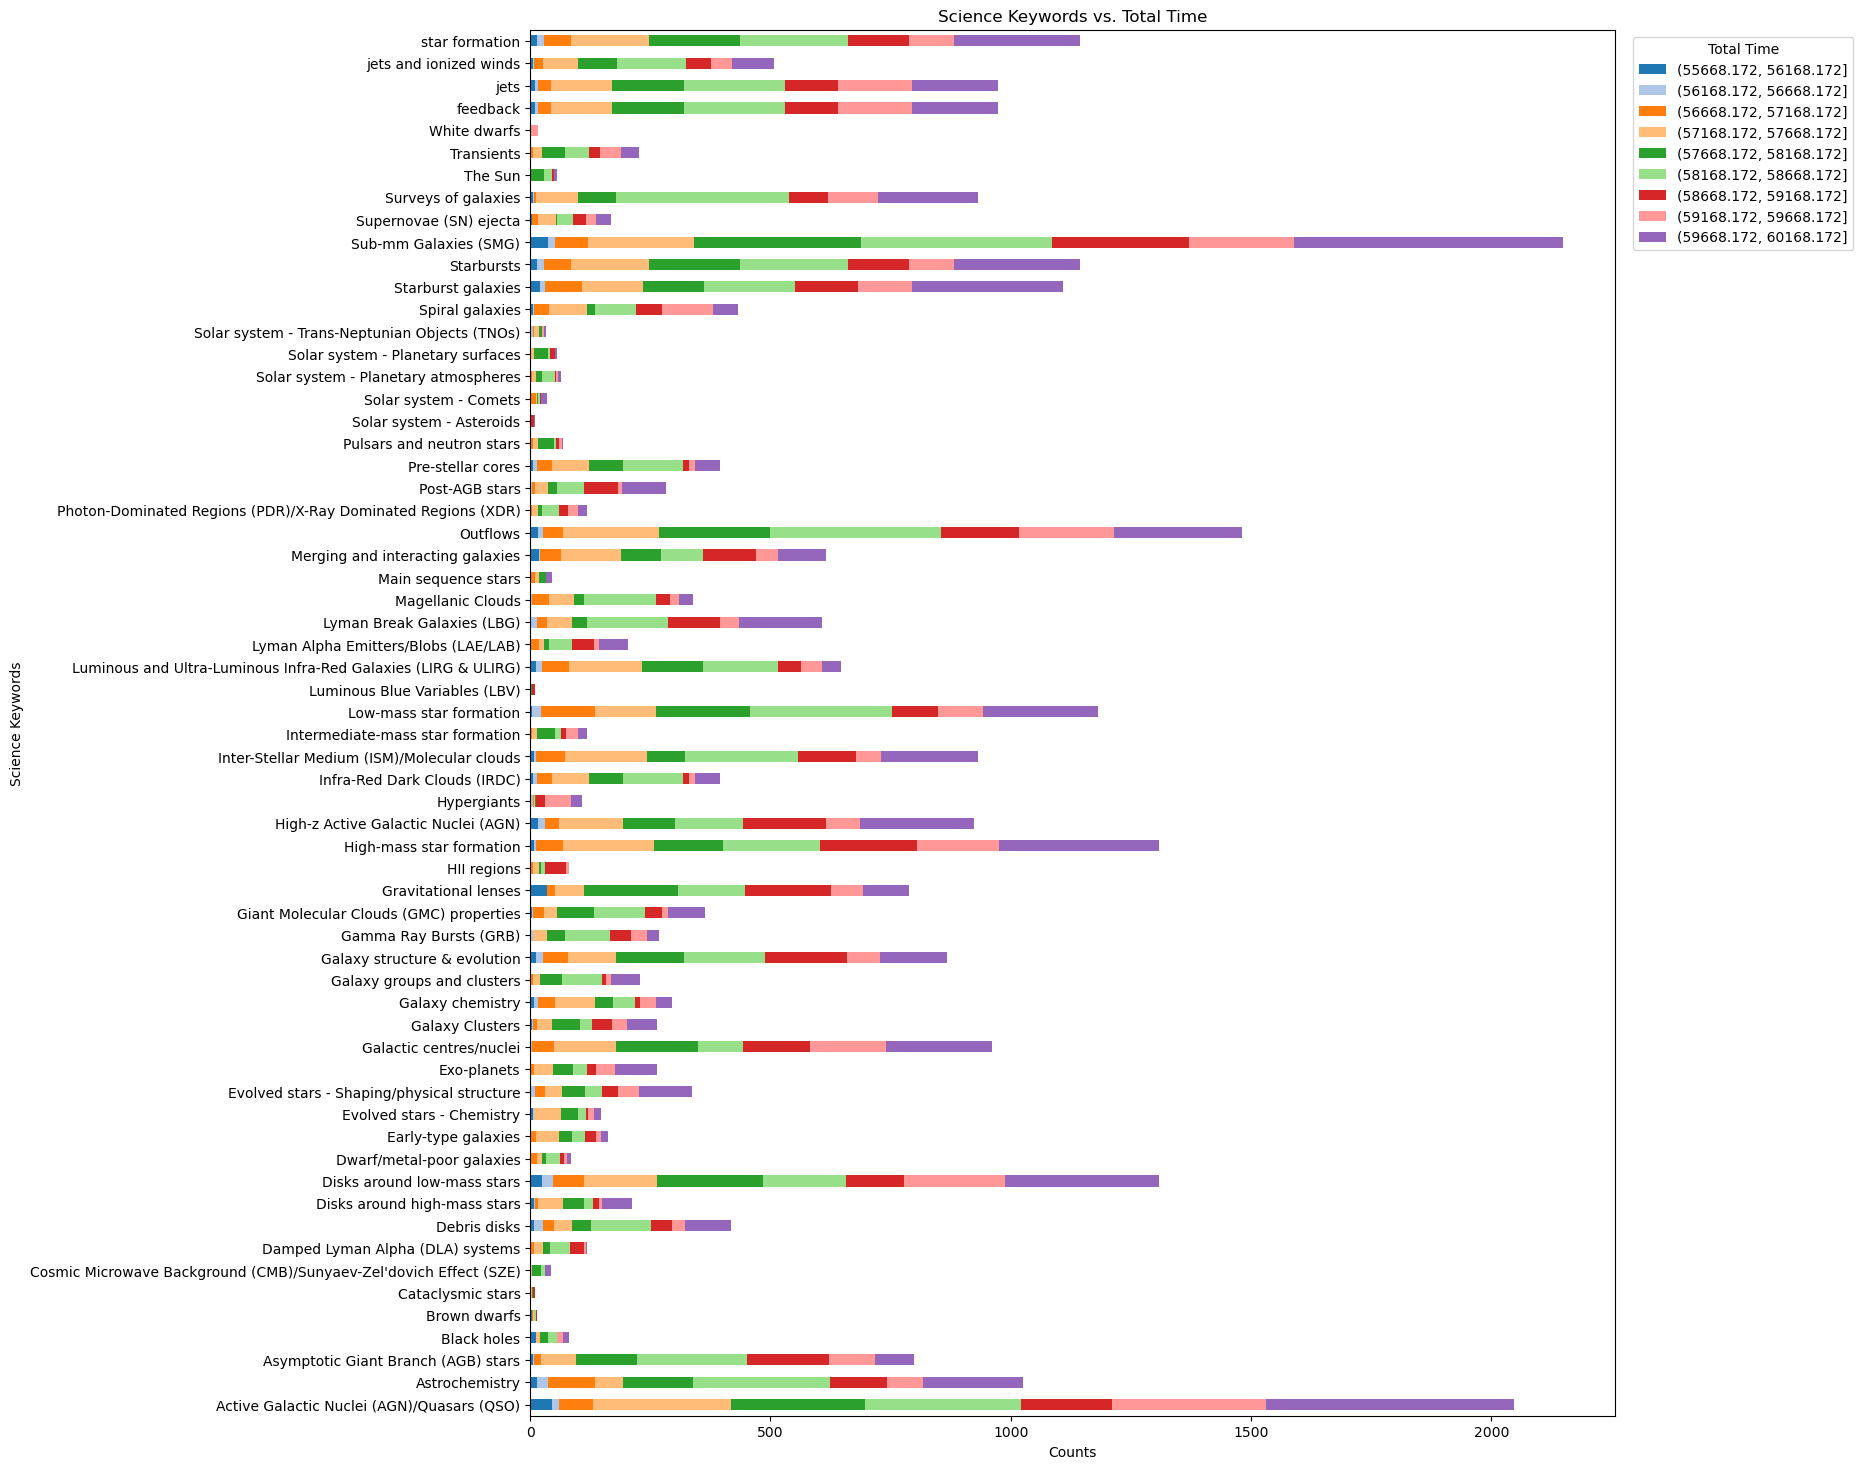

In [7]:
def plot_science_keywords_distributions(service):
    query = """  
            SELECT science_keyword, band_list, member_ous_uid, frequency, t_resolution, t_max, antenna_arrays
            FROM ivoa.obscore  
            WHERE science_observation = 'T'
            AND is_mosaic = 'F'
            """


    db = service.search(query).to_table().to_pandas()
    db = db.drop_duplicates(subset='member_ous_uid')

    # Splitting the science keywords at commas
    db['science_keyword'] = db['science_keyword'].str.split(',')
    db['science_keyword'] = db['science_keyword'].apply(lambda x: [y.strip() for y in x])
    db = db.explode('science_keyword')
    conditions = (db['science_keyword'] == '') | \
                (db['science_keyword'] == 'Exoplanets') | \
                (db['science_keyword'] == 'Galaxy structure &evolution') | \
                (db['science_keyword'] == 'Evolved stars: Shaping/physical structure')
    
    db = db.drop(db[conditions].index)

    db['band_list'] = db['band_list'].str.split(' ')
    db['band_list'] = db['band_list'].apply(lambda x: [y.strip() for y in x])
    db = db.explode('band_list')
    db['max_baseline'] = db['antenna_arrays'].apply(lambda x: get_max_baseline_from_antenna_array(x, master_path))
    db['central_freq'] = db['band_list'].apply(lambda x: get_band_central_freq(int(x)))
    db['fov'] = db['band_list'].apply(lambda x: get_fov_from_band(int(x)))
    db['beam_size'] = db[['central_freq', 'max_baseline']].apply(lambda x: estimate_alma_beam_size(*x), axis=1)
    
    # TESTING 
    #Checking Freq. distribution
    plt.hist(db['fov'], bins=50, alpha=0.75)
    plt.title('FOV Distribution')
    plt.xlabel('FOV arcsec')
    plt.ylabel('Count')
    plt.show()
    #Checking time integration distribution < 30000 s 

    plt.hist(db['t_max'], bins=100, alpha=0.75, log=True)
    plt.title('Total Time Distribution')
    plt.xlabel('Total Time (s)')
    plt.ylabel('Count')
    plt.xscale('log')
    plt.show()

    plt.hist(db['beam_size'], bins=50, alpha=0.75)
    plt.title('Beam Distribution')
    plt.xlabel('Beam arcsec')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Exploding to have one row for each combination of science keyword and band
    #db = db.explode(['science_keyword', 'band_list', 'frequency', 't_resolution', 't_max', 'max_baseline', 'central_freq', 'fov', 'beam_size'])

    #Binning for plots
    db = db[db['t_resolution'] <= 3e4]
    frequency_bins = np.arange(db['frequency'].min(), db['frequency'].max(), 50)  # 50 GHz bins
    db['frequency_bin'] = pd.cut(db['frequency'], bins=frequency_bins)
    time_bins = np.arange(db['t_resolution'].min(), db['t_resolution'].max(), 1000)  # 1000 seconds bins
    db['time_bin'] = pd.cut(db['t_resolution'], bins=time_bins)
    fov_bins = np.arange(db['fov'].min(), db['fov'].max(), 10)  #  10 arcsec bins
    db['fov_bins'] = pd.cut(db['fov'], bins=fov_bins)
    beam_size_bins = np.arange(db['beam_size'].min(), db['beam_size'].max(), 0.1)  # 0.1 arcsec bins
    db['beam_bins'] = pd.cut(db['beam_size'], bins=beam_size_bins)
    total_time_bins = np.arange(db['t_max'].min(), db['t_max'].max(), 500)  # 500 seconds bins
    db['Ttime_bins'] = pd.cut(db['t_max'], bins=total_time_bins)



    db_sk_b = db.groupby(['science_keyword', 'band_list']).size().unstack(fill_value=0)
    db_sk_f = db.groupby(['science_keyword', 'frequency_bin']).size().unstack(fill_value=0)
    db_sk_t = db.groupby(['science_keyword', 'time_bin']).size().unstack(fill_value=0)
    db_sk_fov = db.groupby(['science_keyword', 'fov_bins']).size().unstack(fill_value=0)
    db_sk_bs = db.groupby(['science_keyword', 'beam_bins']).size().unstack(fill_value=0)
    db_sk_Tt = db.groupby(['science_keyword', 'Ttime_bins']).size().unstack(fill_value=0)

    return db_sk_b, db_sk_f, db_sk_t, db_sk_fov, db_sk_bs, db_sk_Tt

db_sk_b, db_sk_f, db_sk_t, db_sk_fov, db_sk_bs, db_sk_Tt = plot_science_keywords_distributions(service)

custom_palette = sns.color_palette("tab20")
sns.set_palette(custom_palette)

plt.rcParams["figure.figsize"] = (14,18)
db_sk_b.plot(kind='barh', stacked=True, color=custom_palette)
plt.title('Science Keywords vs. ALMA Bands')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='ALMA Bands')
plt.show()

plt.rcParams["figure.figsize"] = (14,18)
db_sk_t.plot(kind='barh', stacked=True)
plt.title('Science Keywords vs. Integration Time')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(title='Integration Time', loc='upper left', bbox_to_anchor=(1.01, 1))
plt.show()

plt.rcParams["figure.figsize"] = (14,18)
db_sk_f.plot(kind='barh', stacked=True, color=custom_palette)
plt.title('Science Keywords vs. Source Frequency')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='Frequency')
plt.show()

plt.rcParams["figure.figsize"] = (14,18)
db_sk_fov.plot(kind='barh', stacked=True, color=custom_palette)
plt.title('Science Keywords vs. FoV')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='FoV')
plt.show()

plt.rcParams["figure.figsize"] = (14,18)
db_sk_bs.plot(kind='barh', stacked=True, color=custom_palette)
plt.title('Science Keywords vs. beams_size')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='Beams Size')
plt.show()

plt.rcParams["figure.figsize"] = (14,18)
db_sk_Tt.plot(kind='barh', stacked=True, color=custom_palette)
plt.title('Science Keywords vs. Total Time')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='Total Time')
plt.show()